In [71]:
sc

<SparkContext master=yarn appName=PySparkShell>

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.metrics as metrics
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import correlation
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity

import pyspark
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
from pyspark import SparkConf,SparkContext
from pyspark.sql.types import *
from pyspark.sql import SQLContext

sc.stop()


In [73]:
import warnings
warnings.filterwarnings('ignore')

In [74]:
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

**Creating schemas for the data to be imported from Amazon S3**

In [75]:
ratings_df_schema = StructType(
  [StructField('movie', IntegerType()),
   StructField('user', IntegerType()),
   StructField('rating', DoubleType())]
)

In [76]:
movie_schema = StructType(
  [StructField('movie', IntegerType()),
   StructField('year', IntegerType()),
   StructField('title', StringType())]
)

**Importing all the datasets viz. Training, testing and movies into different dataframes**

In [77]:
train = sqlContext.read.format('csv').schema(ratings_df_schema).load("s3a://movrec/TrainingRatings.txt")
train.show(10)

+-----+-------+------+
|movie|   user|rating|
+-----+-------+------+
|    8|1744889|   1.0|
|    8|1395430|   2.0|
|    8|1205593|   4.0|
|    8|1488844|   4.0|
|    8|1447354|   1.0|
|    8| 306466|   4.0|
|    8|1331154|   4.0|
|    8|1818178|   3.0|
|    8| 991725|   4.0|
|    8|1987434|   4.0|
+-----+-------+------+
only showing top 10 rows



In [78]:
test = sqlContext.read.format('csv').schema(ratings_df_schema).load('s3a://movrec/TestingRatings.txt')
test.show(10)

+-----+-------+------+
|movie|   user|rating|
+-----+-------+------+
|    8| 573364|   1.0|
|    8|2149668|   3.0|
|    8|1089184|   3.0|
|    8|2465894|   3.0|
|    8| 534508|   1.0|
|    8| 992921|   4.0|
|    8| 595054|   4.0|
|    8|1298304|   4.0|
|    8|1661600|   4.0|
|    8| 553787|   2.0|
+-----+-------+------+
only showing top 10 rows



In [79]:
movies= sqlContext.read.format('csv').schema(movie_schema).load("s3a://movrec/movie_titles.txt")
movies.show(10)

+-----+----+--------------------+
|movie|year|               title|
+-----+----+--------------------+
|    1|2003|     Dinosaur Planet|
|    2|2004|Isle of Man TT 20...|
|    3|1997|           Character|
|    4|1994|Paula Abdul's Get...|
|    5|2004|The Rise and Fall...|
|    6|1997|                Sick|
|    7|1992|               8 Man|
|    8|2004|What the #$*! Do ...|
|    9|1991|Class of Nuke 'Em...|
|   10|2001|             Fighter|
+-----+----+--------------------+
only showing top 10 rows



In [107]:
train = train.join(movies, on=['movie'], how='inner')
train.show(10)

+-----+-------+------+----+--------------------+----+--------------------+
|movie|   user|rating|year|               title|year|               title|
+-----+-------+------+----+--------------------+----+--------------------+
|    8|1744889|   1.0|2004|What the #$*! Do ...|2004|What the #$*! Do ...|
|    8|1395430|   2.0|2004|What the #$*! Do ...|2004|What the #$*! Do ...|
|    8|1205593|   4.0|2004|What the #$*! Do ...|2004|What the #$*! Do ...|
|    8|1488844|   4.0|2004|What the #$*! Do ...|2004|What the #$*! Do ...|
|    8|1447354|   1.0|2004|What the #$*! Do ...|2004|What the #$*! Do ...|
|    8| 306466|   4.0|2004|What the #$*! Do ...|2004|What the #$*! Do ...|
|    8|1331154|   4.0|2004|What the #$*! Do ...|2004|What the #$*! Do ...|
|    8|1818178|   3.0|2004|What the #$*! Do ...|2004|What the #$*! Do ...|
|    8| 991725|   4.0|2004|What the #$*! Do ...|2004|What the #$*! Do ...|
|    8|1987434|   4.0|2004|What the #$*! Do ...|2004|What the #$*! Do ...|
+-----+-------+------+---

**Converting the data from spark to Pandas dataframe for anaylysis**

In [80]:
training_data = train.toPandas()
testing_data = test.toPandas()
movie_data = movies.toPandas()

**Calculating the distinct users in testing data**

In [81]:
testing_data["user"].nunique()

27555

Text(0, 0.5, 'Count')

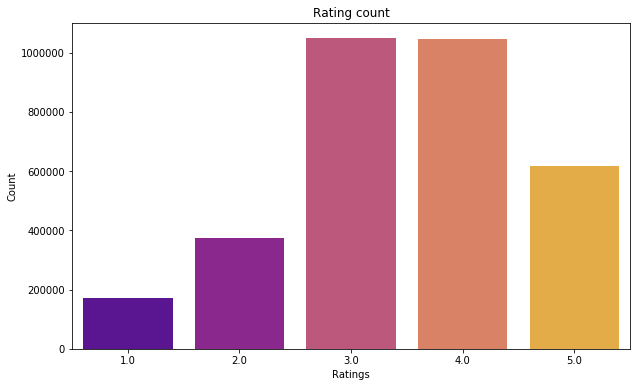

In [82]:
plt.figure(figsize=(10,6))
sns.countplot(training_data["rating"], palette = "plasma")
plt.title("Rating count")
plt.xlabel("Ratings")
plt.ylabel("Count")

Text(0, 0.5, 'Rating count')

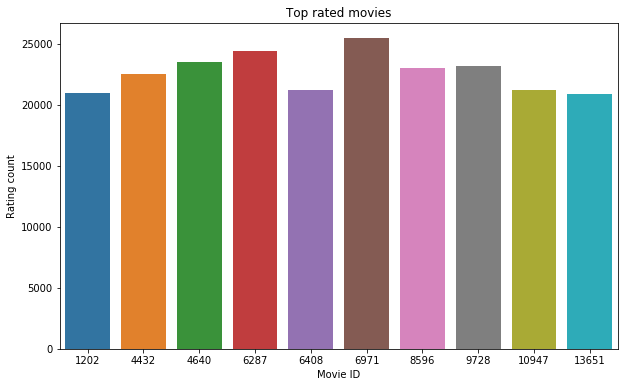

In [83]:
plt.figure(figsize=(10,6))
mov_rat = pd.DataFrame(training_data["rating"].groupby(training_data["movie"]).count())
top10_mov = mov_rat.sort_values("rating", ascending =False)[:10]
top10_mov = top10_mov.reset_index()
sns.barplot(top10_mov["movie"],top10_mov["rating"])
plt.title("Top rated movies")
plt.xlabel("Movie ID")
plt.ylabel("Rating count")

**Creating a subset for testing the two collaborative filter methods**

In [84]:
subset_train = training_data[:10000]
subset_train.tail()

,movie,user,rating
9995,28,538321,5.0
9996,28,968133,4.0
9997,28,1523919,4.0
9998,28,1230004,3.0
9999,28,1988375,3.0


**Creating a item-item table for testing this collaborative method**

In [85]:
item_item_filter = subset_train.pivot(
    index='movie',
    columns='user',
    values='rating'
).fillna(0).astype(np.int32)

In [86]:
item_item_filter.head()

user,7,906,1333,1442,1500,1527,2000,2213,2678,2905,...,2646712,2647197,2647406,2648085,2648181,2648287,2648465,2648589,2648730,2648885
movie,,,,,,,,,,,,,,,,,,,,,
8,5,0,3,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
28,4,3,2,4,1,5,4,5,2,5,...,5,0,3,5,5,3,4,3,4,4


**Converting the table into a matrix for further evaluation**

In [87]:
item_matrix = csr_matrix(item_item_filter.values)

In [88]:
item_matrix.toarray()

array([[5, 0, 3, ..., 0, 0, 0],
       [4, 3, 2, ..., 3, 4, 4]], dtype=int32)

**Finding cosine similarity between the entitites and averaging them out**

In [89]:
item_sim=cosine_similarity(X=item_matrix.T,dense_output=False)

In [90]:
item_sim.toarray().mean()

0.6359496022864369

**Creating a user-user table for testing this collaborative method**

In [91]:
user_user_filter = subset_train.pivot(
    index='user',
    columns='movie',
    values='rating'
).fillna(0).astype(np.int32)

In [92]:
user_user_filter.head()

movie,8,28
user,,
7,5,4
906,0,3
1333,3,2
1442,0,4
1500,0,1


**Converting the table into a matrix for further evaluation**

In [93]:
user_matrix = csr_matrix(user_user_filter.values)

In [94]:
user_matrix.toarray()

array([[5, 4],
       [0, 3],
       [3, 2],
       ...,
       [0, 3],
       [0, 4],
       [0, 4]], dtype=int32)

**Finding cosine similarity between the entitites and averaging them out**

In [95]:
user_sim=cosine_similarity(X=user_matrix.T,dense_output=False)

In [96]:
user_sim.toarray().mean()

0.5585008721224045

**The matrices above shows that we can find higher similarity rates with the item-item collaborative techniques which makes the job of selecting new recommendations easier, making it a better technique in this case**

In [102]:
def knn_model(uid,matrix):
    model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute') 
    model_knn.fit(matrix)
    loc = matrix.index.get_loc(uid)
    distance, indices = model_knn.kneighbors(matrix.iloc[loc, :].values.reshape(1, -1), n_neighbors = 10)

    return distance, indices
    

In [98]:
def simuser(uid,matrix):
    dist, index = knn_model(uid,matrix)
    sim_val = 1-dist.flatten()
            
    return sim_val,index

**Finding the similarity of a user with all other items in the matrix**

In [101]:
simuser(28,item_item_filter)

(array([1.        , 0.11700174]), array([[1, 0]]))

In [103]:
simuser(1500,user_user_filter)

(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([[5678, 5681, 5674, 5675, 5676, 5677, 5670, 5679, 5689, 5685]]))

**Training the matrices using the ALS algorithm from ML library of pyspark which is specifically made to make recommendation systems**

In [108]:
als = ALS(maxIter=10, regParam=0.22, userCol="user", itemCol="movie", ratingCol="rating",
          coldStartStrategy="drop")
model = als.fit(train)

# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)

rmse_val = RegressionEvaluator(metricName="rmse", labelCol="rating",predictionCol="prediction")


mse_val = RegressionEvaluator(metricName="mse", labelCol="rating",predictionCol="prediction")
                                            
rmse = rmse_val.evaluate(predictions)
mse = mse_val.evaluate(predictions)

print("Mean squared error = " + str(mse))
print("Root-mean-square error = " + str(rmse))

Mean squared error = 0.8204542053580549
Root-mean-square error = 0.9057892720484466


In [109]:
predictions.show(10)

+-----+-------+------+----------+
|movie|   user|rating|prediction|
+-----+-------+------+----------+
| 2366|1484561|   4.0| 3.2380471|
| 2366| 397212|   2.0| 2.3661156|
| 2366| 298900|   2.0| 2.5993316|
| 2366| 542323|   2.0|  2.386564|
| 2366| 692235|   3.0|  2.999948|
| 2366|2552319|   3.0| 2.2941983|
| 2366| 799826|   2.0| 2.7930992|
| 2366|1848661|   3.0|  3.080878|
| 2366|1870288|   2.0| 3.6322794|
| 2366|2522831|   3.0| 2.6743345|
+-----+-------+------+----------+
only showing top 10 rows



**Adding personal records to the training data and using union operator to do it**

In [54]:
user_df = sqlContext.read.format('csv').schema(ratings_df_schema).load('s3://movrec/self-user.txt')
user_df.show(2)

+-------+------+------+
|movieId|userId|rating|
+-------+------+------+
|      8|     0|   4.0|
|     28|     0|   3.0|
+-------+------+------+
only showing top 2 rows



In [55]:
train = train.union(user_df)

In [60]:
my_data = train_d.filter(train_d.user == 0)
my_data.count()

14

**Recommedations for the movies I rated**

In [59]:
# users = train_d.select(als.getUserCol()).where(train_d.user == 0)
userSubsetRecs = model.recommendForUserSubset(my_data, 10)
userSubsetRecs.show(truncate =False)

+----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user|recommendations                                                                                                                                                                               |
+----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0   |[[12293, 4.9477453], [3033, 4.946212], [16147, 4.9320965], [5760, 4.910286], [7569, 4.9082975], [14648, 4.8423414], [4238, 4.8208046], [3290, 4.819887], [10080, 4.812768], [1472, 4.8005705]]|
+----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+



In [62]:
my_recc = [3033,16147,12293,7569,5760,14648,4238,10080,3290,1472]

In [63]:
recc_df = movies[movies.movie.isin(my_recc)]
recc_df.head(10)

[Row(movie=1472, year=2004, title='The Stink of Flesh'),
 Row(movie=3033, year=2005, title='Ghost in the Shell: Stand Alone Complex: 2nd Gig'),
 Row(movie=3290, year=1974, title='The Godfather'),
 Row(movie=4238, year=2000, title='Inu-Yasha'),
 Row(movie=5760, year=2001, title='The Sopranos: Season 3'),
 Row(movie=7569, year=2004, title='Dead Like Me: Season 2'),
 Row(movie=10080, year=2001, title='Six Feet Under: Season 2'),
 Row(movie=12293, year=1972, title='The Godfather'),
 Row(movie=14648, year=2003, title='Finding Nemo (Full-screen)'),
 Row(movie=16147, year=1999, title='The Sopranos: Season 1')]